# Getting Started guide for Implementing your Black-Box Optimization Algorithm for Pseudo-Boolean Problems

This notebook is designed to guide you through the process of creating, benchmarking and analyzing your optimization algorithm for pseudo-boolean optimization (PBO) problems. 
While this guide is built on the IOHprofiler suite, no prior knowledge of these tools is required. This notebook is standalone, so it will explain only the parts required for running and evaluating your algorithm on binary optimization problems. For more details on IOHprofiler, we refer to iohprofiler.github.io.

Pseudo-boolean optimization deals with problems where the decision variables are binary (0 or 1), which is common in many real-world applications such as feature selection, network design, and combinatorial optimization.

This notebook will provide examples based on several standard pseudo-boolean optimization problems, and at the end introduce the submodular problems which you will work with for your assignement. 

This notebook is structured as follows:
- Installing the required dependencies
- Accessing pseudo-boolean benchmark problems
- Implementing your algorithm
- Investigating your algorithm's performance
- Comparing different algorithm strategies on PBO problems

## Step 1: Installing the required packages

To access the pseudo-boolean optimization (PBO) benchmark problems and corresponding logging functionality, we use the IOHexperimenter package, available on pypi as 'ioh'. 

For the later processing of the benchmark data, we will use the newly released IOHinspector package. This can be cloned and installed from GitHub directly, or installed as 'iohinspector' from pypi.

In [1]:
%pip install ioh
%pip install iohinspector --upgrade
%pip install tqdm networkx scipy # for some additional functionality

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We will now load these packages, as well as some default packages which we will use for the example algorithm

In [2]:
import iohinspector
import ioh
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm 
import matplotlib.pyplot as plt
import os

## Step 2: The pseudo-boolean optimization problems
In IOHexperimenter, problems can be seen as just normal python functions, but with some useful meta-data attached to them. For these examples, we will be using several problems from the PBO (Pseudo-Boolean Optimization) problem suite: 
* Problem 1, OneMax - Maximize the number of 1s in a binary string
* Problem 2, LeadingOnes - Maximize the number of leading 1s
* Problem 18, LABS (Low Autocorrelation Binary Sequences) - Minimize the autocorrelation
* Problem 19, IsingRing - Ising model on a ring topology

We can access these problems as follows:

In [3]:
problem = ioh.get_problem(1, instance=1, dimension=10, problem_class=ioh.ProblemClass.PBO) 
# Or using the name: problem = ioh.get_problem("OneMax", instance=1, dimension=10, problem_class=ioh.ProblemClass.INTEGER)

Here, the arguments we give are as follows: first, the problem identifier, which we can use since we are working with the PBO function suite. Second, the instance of the problem. Problem instances are different transformations of the same underlying problem, and the dimension argument specifies the number of binary variables. Finally, we specify `problem_class=ioh.ProblemClass.INTEGER` to access the pseudo-boolean problems instead of the default continuous problems.

In [4]:
# Let's demonstrate how different PBO problems behave with small examples
import numpy as np

# Create some example problems
problems = [
    ioh.get_problem(1, instance=1, dimension=5, problem_class=ioh.ProblemClass.PBO),  # OneMax
    ioh.get_problem(2, instance=1, dimension=5, problem_class=ioh.ProblemClass.PBO),  # LeadingOnes  
    ioh.get_problem(18, instance=1, dimension=5, problem_class=ioh.ProblemClass.PBO), # LABS
]

print("Example evaluations for different PBO problems (dimension=5):")
print("=" * 60)

# Generate some example binary vectors
test_vectors = [
    [0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1], 
    [1, 1, 0, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 1, 1, 0]
]

for i, problem in enumerate(problems):
    print(f"\n{problem.meta_data.name} (ID {problem.meta_data.problem_id}):")
    print("-" * 40)
    for vec in test_vectors:
        result = problem(vec)
        print(f"  f({vec}) = {result:.3f}")
    problem.reset()  # Reset for next use

Example evaluations for different PBO problems (dimension=5):

OneMax (ID 1):
----------------------------------------
  f([0, 0, 0, 0, 0]) = 0.000
  f([1, 1, 1, 1, 1]) = 5.000
  f([1, 1, 0, 0, 0]) = 2.000
  f([1, 0, 1, 0, 1]) = 3.000
  f([0, 1, 1, 1, 0]) = 3.000

LeadingOnes (ID 2):
----------------------------------------
  f([0, 0, 0, 0, 0]) = 0.000
  f([1, 1, 1, 1, 1]) = 5.000
  f([1, 1, 0, 0, 0]) = 2.000
  f([1, 0, 1, 0, 1]) = 1.000
  f([0, 1, 1, 1, 0]) = 0.000

LABS (ID 18):
----------------------------------------
  f([0, 0, 0, 0, 0]) = 0.417
  f([1, 1, 1, 1, 1]) = 0.417
  f([1, 1, 0, 0, 0]) = 1.250
  f([1, 0, 1, 0, 1]) = 0.417
  f([0, 1, 1, 1, 0]) = 2.083


The meta-data of the problem (e.g. problem dimensionality, variable bounds) can be accessed as follows:

In [5]:
problem = ioh.get_problem(1, instance=1, dimension=10, problem_class=ioh.ProblemClass.PBO)
print(f"Number of variables: {problem.meta_data.n_variables}")
print(f"Lower bounds: {problem.bounds.lb}")
print(f"Upper bounds: {problem.bounds.ub}")

Number of variables: 10
Lower bounds: [0 0 0 0 0 0 0 0 0 0]
Upper bounds: [1 1 1 1 1 1 1 1 1 1]


This problem functions exactly as you might expect from a python function

In [6]:
# Generate a random binary vector within the problem bounds
x0 = np.random.randint(problem.bounds.lb[0], problem.bounds.ub[0] + 1, size=problem.meta_data.n_variables)

print(f"Random binary vector: {x0}")

# Evaluation happens like a 'normal' objective function would
result = problem(x0)
print(f"Function value: {result}")

Random binary vector: [0 1 0 1 0 1 1 1 0 1]
Function value: 6.0


However, it keeps track of the optimization process internally, so it has a state we can use to check e.g. what was the best solution we tried so far

In [7]:
problem.state

<State evaluations: 1 final_target_found: false current_best: <Solution x: [0, 1, 0, 1, 0, 1, 1, 1, 0, 1] y: 6>>

A note on problem instances: to make sure the optimization algorithms are not biased, we can create different instances of these problems. For example, a different instance of OneMax still has the same structure, but instead of trying to find the all 1s string, we have an unknown target string (or equivalently, we have a random bitstring which our input is being XORed with before being evaluated). We can also transform the output values to check e.g. that our algorithm also works with negative function values:

In [8]:
# Create some example problems
problems = [
    ioh.get_problem(1, instance=1, dimension=5, problem_class=ioh.ProblemClass.PBO),  # OneMax
    ioh.get_problem(1, instance=2, dimension=5, problem_class=ioh.ProblemClass.PBO),  # OneMax with different instance  
    ioh.get_problem(1, instance=3, dimension=5, problem_class=ioh.ProblemClass.PBO), # OneMax with different instance
]

print("Example evaluations for different PBO problems (dimension=5):")
print("=" * 60)

# Generate some example binary vectors
test_vectors = [
    [0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1], 
    [1, 1, 0, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 1, 1, 0]
]

for i, problem in enumerate(problems):
    print(f"\n{problem.meta_data.name} (Instance {problem.meta_data.instance}) (Target: {problem.optimum}):")
    print("-" * 40)
    for vec in test_vectors:
        result = problem(vec)
        print(f"  f({vec}) = {result:.3f}")
    problem.reset()  # Reset for next use

Example evaluations for different PBO problems (dimension=5):

OneMax (Instance 1) (Target: <Solution x: [1, 1, 1, 1, 1] y: 5>):
----------------------------------------
  f([0, 0, 0, 0, 0]) = 0.000
  f([1, 1, 1, 1, 1]) = 5.000
  f([1, 1, 0, 0, 0]) = 2.000
  f([1, 0, 1, 0, 1]) = 3.000
  f([0, 1, 1, 1, 0]) = 3.000

OneMax (Instance 2) (Target: <Solution x: [1, 1, 1, 0, 1] y: -306.18729325532325>):
----------------------------------------
  f([0, 0, 0, 0, 0]) = -313.559
  f([1, 1, 1, 1, 1]) = -308.030
  f([1, 1, 0, 0, 0]) = -309.873
  f([1, 0, 1, 0, 1]) = -308.030
  f([0, 1, 1, 1, 0]) = -311.716

OneMax (Instance 3) (Target: <Solution x: [0, 0, 0, 0, 1] y: 818.3813842131668>):
----------------------------------------
  f([0, 0, 0, 0, 0]) = 813.871
  f([1, 1, 1, 1, 1]) = 800.341
  f([1, 1, 0, 0, 0]) = 804.851
  f([1, 0, 1, 0, 1]) = 809.361
  f([0, 1, 1, 1, 0]) = 800.341


# Step 3: Implementing an optimization algorithm

We can now start creating a simple optimization algorithm, e.g. basic random search. Note that we can directly access the problems meta-data where required. 

In [9]:
class RandomSearch:
    'Simple random search algorithm for binary optimization'
    def __init__(self, budget: int):
        self.budget: int = budget
        
    def __call__(self, problem: ioh.problem.IntegerSingleObjective) -> None:
        'Evaluate the problem n times with a randomly generated binary solution'
        
        for _ in range(self.budget):
            # Generate random binary vector (0s and 1s)
            x = np.random.randint(0, 2, size=problem.meta_data.n_variables)            
            problem(x)

To run an optimization experiment, we want to run the algorithm multiple times. Here, we have a short function which helps us do this

In [10]:
# If we want to perform multiple runs with the same objective function, after every run, the problem has to be reset, 
# such that the internal state reflects the current run.
def run_experiment(problem, algorithm, n_runs=5, verbose=True):
    for run in tqdm(range(n_runs)):
        
        # Run the algorithm on the problem
        algorithm(problem)

        # print the best found for this run
        if verbose:
            print(f"run: {run+1} - best found:{problem.state.current_best.y: .3f}")

        # Reset the problem
        problem.reset()

To illustrate how this works, we use a basic random search

In [11]:
run_experiment(problem, RandomSearch(100))

100%|██████████| 5/5 [00:00<00:00, 323.59it/s]

run: 1 - best found: 818.381
run: 2 - best found: 818.381
run: 3 - best found: 818.381
run: 4 - best found: 818.381
run: 5 - best found: 818.381


Finally, we should make sure that our experiment records the correct data. To do this, we can use a 'logger' object form IOH, which we attach to the problem to handle all of this for us. 

In [12]:
import os

logger = ioh.logger.Analyzer(
        root=os.getcwd(),                  # Store data in the current working directory
        folder_name="PBO_RS_Test",         # in a folder named: 'PBO_RS_Test'
        algorithm_name="RandomSearch_PBO", # meta-data for the algorithm used to generate these results
)

# this automatically creates a folder 'PBO_RS_Test' in the current working directory
# if the folder already exists, it will given an additional number to make the name unique
logger

<Analyzer /home/tom/mpri/heu/project/PBO_RS_Test-1>

With this logger, we can now set up an experiment which loops over the different problems we are interested in:

In [13]:
for fid in [1, 2, 18, 19]:  # OneMax, LeadingOnes, LABS, IsingRing
    problem = ioh.get_problem(fid, instance=1, dimension=20, problem_class=ioh.ProblemClass.INTEGER)
    problem.attach_logger(logger)
    run_experiment(problem, RandomSearch(5000), n_runs=15, verbose=False)
# After the experiment is done, we can close the logger
logger.close()

100%|██████████| 15/15 [00:00<00:00, 26.45it/s]


## Step 4: Loading the benchmark data

To process the data from an optimization algorithm, we can use a variety of tools. Since we are working within the IOHprofiler framework, we can directly upload our data to the IOHanalyzer webpage (iohanalyzer.liacs.nl), where we can interactively analyze the performance and compare to data from a variety of other sources. We can alternatively use the IOHinspector package, which provides access to a variety of analysis methods in the form of a python package, which we will show here. 

IOHinspector works by first creating a `DataManager` object, which we then point to the folders we want to include in the analysis. 

In [14]:
manager = iohinspector.DataManager()
manager.add_folder("PBO_RS_Test")

This object keeps track of the meta-data, and can be used to e.g. filter data before loading the underlying performance files into memory.

In [15]:
manager.overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64
1,"""RandomSearch_PBO""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,1,5000,18.0


Loading the data can be done using the `load` functionality. This has the option to make the data monotonic (e.g. extract the best-so-far as the performance measure) and to include the meta-data into the resulting dataframe for convenient aggregation in plots. 

In [16]:
df = manager.load(True, True)

This data can then be analyzed with a variety of plotting functionality, for example the standard fixed-budget plot for a single function:

Text(0.5, 1.0, 'Fixed Budget Performance on OneMax Problem')

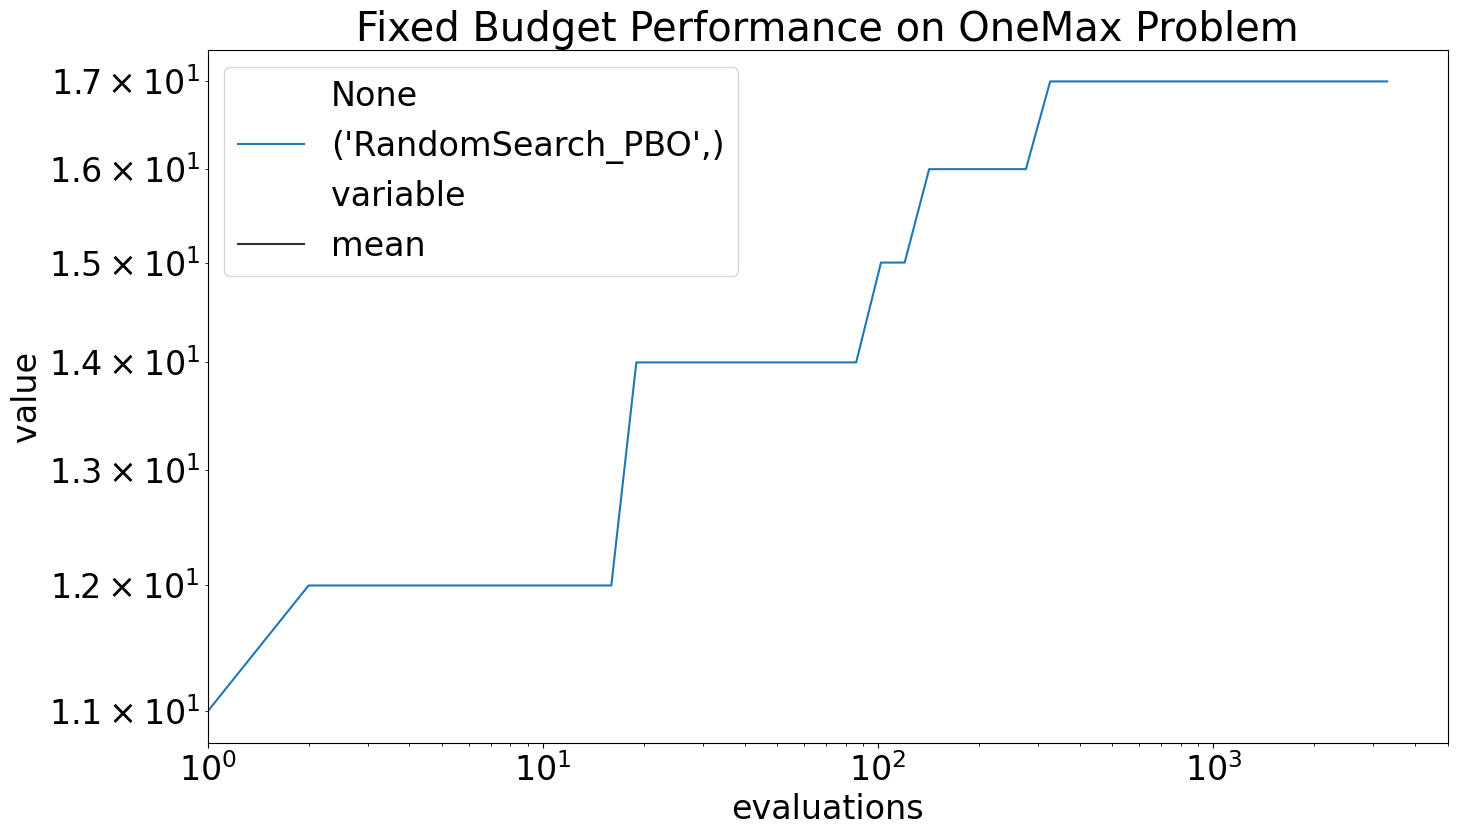

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
# Plot results for OneMax (function_id = 1)
dt_plot = iohinspector.plot.single_function_fixedbudget(df.filter(pl.col("function_id") == 1), ax=ax, maximization=True, measures=['mean']) #We need to specify maximization=True 
ax.set_xlim(1, 5000)
ax.set_title("Fixed Budget Performance on OneMax Problem")

# Step 5: Creating an actual algorithm and analyzing its behavior

Some problems in the PBO suite are relatively straightforward to understand, while others have a more difficult optimization structure. As such, we can use performance analysis on these problems to learn about the strengths and weaknesses of different algorithms or parameter settings. To illustrate how we could go about this, we can set up a simple evolutionary algorithm for binary optimization and look at the impact of different mutation rates on convergence.

In [18]:
# Let's examine the characteristics of different PBO problems
import numpy as np

problems_info = [
    (1, "OneMax", "Maximize number of 1s"),
    (2, "LeadingOnes", "Maximize leading 1s"), 
    (18, "LABS", "Low autocorrelation"),
    (19, "IsingRing", "Ising model on ring")
]

print("PBO Problem Characteristics (dimension=10):")
print("=" * 60)

for fid, name, description in problems_info:
    problem = ioh.get_problem(fid, instance=1, dimension=10, problem_class=ioh.ProblemClass.INTEGER)
    
    print(f"\n{name} (ID {fid}): {description}")
    print("-" * 40)
    
    # Test some specific patterns
    test_cases = [
        ("All zeros", [0] * 10),
        ("All ones", [1] * 10),
        ("Alternating", [i % 2 for i in range(10)]),
        ("First half", [1] * 5 + [0] * 5)
    ]
    
    for case_name, vector in test_cases:
        result = problem(vector)
        print(f"  {case_name:12} {vector} -> {result:.3f}")
    
    problem.reset()

print("\nThese different problem characteristics will help us understand")
print("how different algorithm strategies perform on various landscapes.")

PBO Problem Characteristics (dimension=10):

OneMax (ID 1): Maximize number of 1s
----------------------------------------
  All zeros    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -> 0.000
  All ones     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -> 10.000
  Alternating  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1] -> 5.000
  First half   [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] -> 5.000

LeadingOnes (ID 2): Maximize leading 1s
----------------------------------------
  All zeros    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -> 0.000
  All ones     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -> 10.000
  Alternating  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1] -> 0.000
  First half   [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] -> 5.000

LABS (ID 18): Low autocorrelation
----------------------------------------
  All zeros    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -> 0.175
  All ones     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -> 0.175
  Alternating  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1] -> 0.175
  First half   [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] -> 0.400

IsingRing (ID 19): Ising model on ring
-----------------

In [19]:
class BinaryEvolutionaryAlgorithm:
    """
    Simple (1+1) Evolutionary Algorithm for binary optimization with bit-flip mutation.
    """
    def __init__(self, budget: int, mutation_rate: float):
        self.budget = budget
        self.mutation_rate = mutation_rate

    def __call__(self, problem: ioh.problem.IntegerSingleObjective) -> None:
        # Initialize with a random binary solution
        x = np.random.randint(0, 2, size=problem.meta_data.n_variables)
        problem(x)

        while problem.state.evaluations < self.budget and not problem.state.optimum_found:
            # Mutate: flip bits with given probability
            candidate = problem.state.current_best.x.copy()
            
            # Bit-flip mutation: flip each bit with probability mutation_rate
            for i in range(len(candidate)):
                if np.random.random() < self.mutation_rate:
                    candidate[i] = 1 - candidate[i]  # Flip bit (0->1, 1->0)
            
            problem(candidate)

The problem's state keeps track of the best-so-far solution, and the state tracks the number of evaluated solutions and whether the optimal solution is found. This is what is used by the logger to record performance. 

In [20]:
for idx, mutation_rate in enumerate([0.01, 0.1, 0.5]):  # Different bit-flip probabilities
    logger = ioh.logger.Analyzer(
        root=os.getcwd(), 
        folder_name=f"PBO_EA{idx}",     
        algorithm_name=f"BinaryEA-{mutation_rate}",    # Include mutation rate in algorithm name
    )
    logger.add_experiment_attribute("mutation_rate", f"{mutation_rate}") # Add as experiment attribute
    
    for fid in [1, 2, 18, 19]:  # OneMax, LeadingOnes, LABS, IsingRing
        problem = ioh.get_problem(fid, instance=1, dimension=20, problem_class=ioh.ProblemClass.INTEGER)
        problem.attach_logger(logger)
        run_experiment(problem, BinaryEvolutionaryAlgorithm(2000, mutation_rate), n_runs=15, verbose=False)
    logger.close()

100%|██████████| 15/15 [00:00<00:00, 43.04it/s]


After the experiment is finished, we can again load the data using IOHinspector:

In [21]:
# We can reuse the DataManager from before if we want to have random search in the comparison
for idx in range(3):
    manager.add_folder(f"PBO_EA{idx}")
df = manager.load(True, True)

In [22]:
df.filter(pl.col("function_id") == 1)

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y,mutation_rate,evaluations,raw_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64,f64,u64,f64
1,"""RandomSearch_PBO""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,1,5000,18.0,null,1,11.0
1,"""RandomSearch_PBO""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,1,5000,18.0,null,2,12.0
1,"""RandomSearch_PBO""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,1,5000,18.0,null,18,14.0
1,"""RandomSearch_PBO""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,1,5000,18.0,null,100,15.0
1,"""RandomSearch_PBO""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,1,5000,18.0,null,121,16.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
180,"""BinaryEA-0.5""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,14,2000,18.0,0.5,1023,18.0
181,"""BinaryEA-0.5""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,15,2000,17.0,0.5,1,13.0
181,"""BinaryEA-0.5""","""algorithm_info""","""unknown_suite""","""OneMax""",1,20,1,15,2000,17.0,0.5,51,14.0


We can then plot the fixed-budget performance again:

Text(0.5, 1.0, 'Fixed Budget Performance on OneMax Problem')

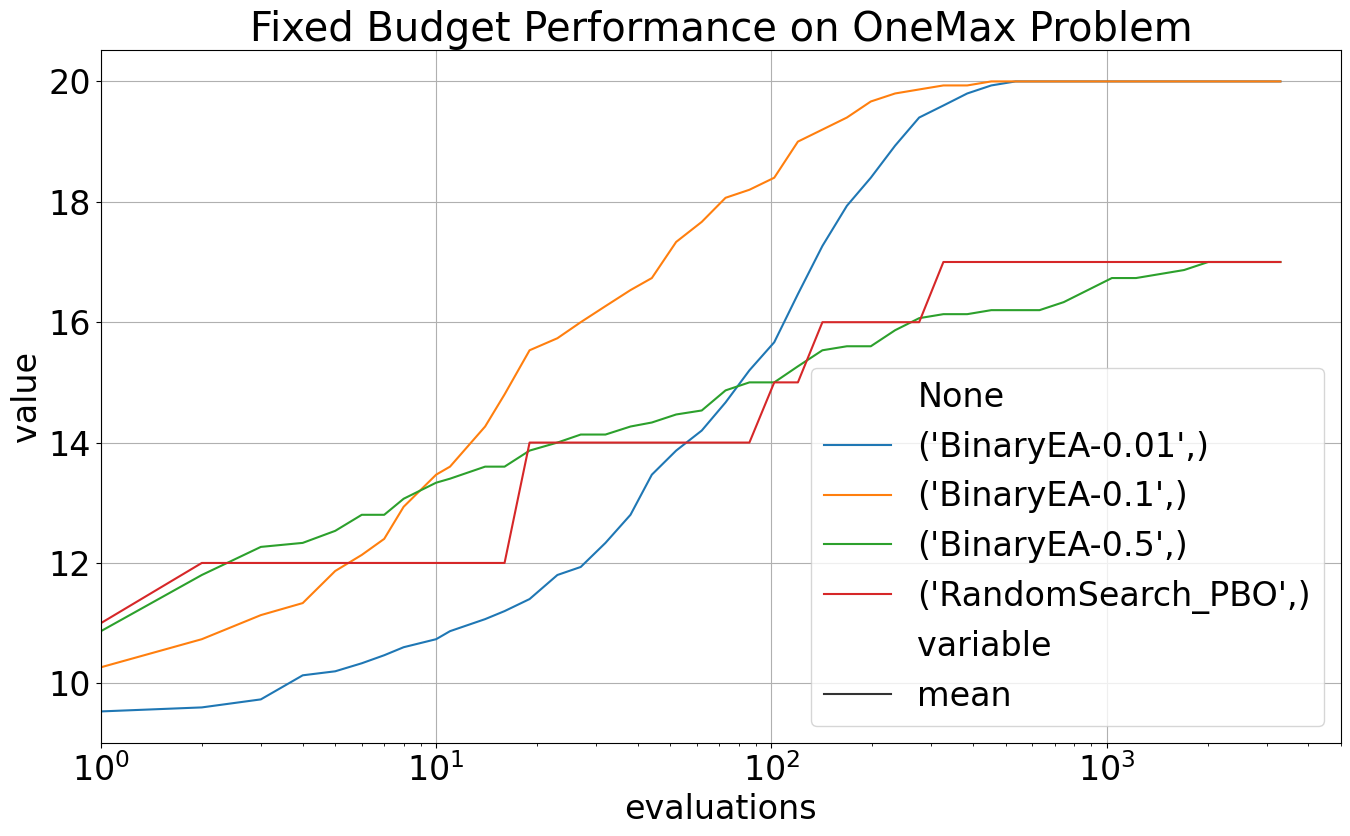

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
# Plot results for OneMax (function_id = 1)
dt_plot = iohinspector.plot.single_function_fixedbudget(df.filter(pl.col("function_id") == 1), ax=ax, maximization=True, measures=['mean']) #We need to specify maximization=True 
ax.set_xlim(1, 5000)
ax.grid()
ax.set_yscale('linear')
ax.set_title("Fixed Budget Performance on OneMax Problem")

Text(0.5, 1.0, 'Fixed Budget Performance on LABS Problem')

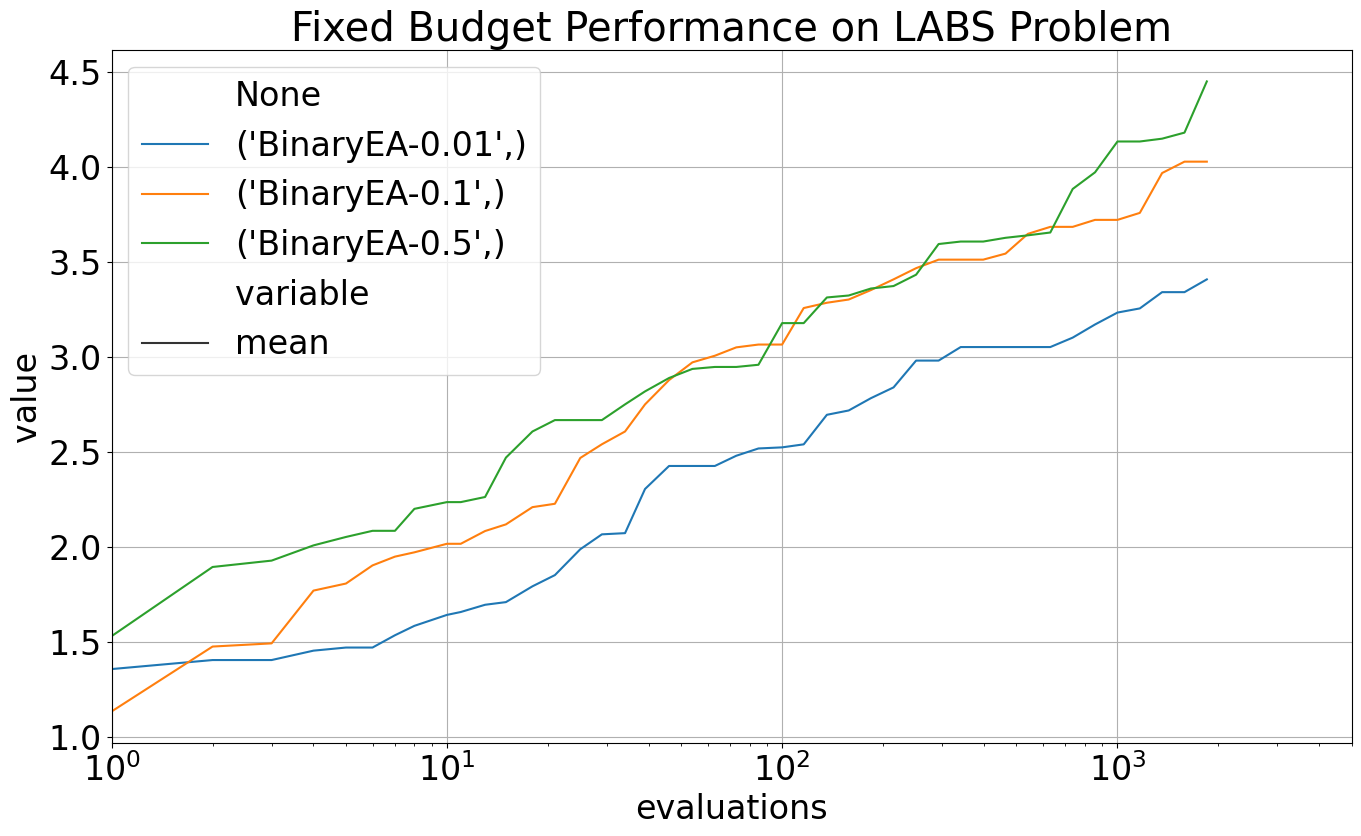

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))
dt_plot = iohinspector.plot.single_function_fixedbudget(df.filter(pl.col("function_id") == 18), ax=ax, maximization=True, measures=['mean']) #We need to specify maximization=True 
ax.set_xlim(1, 5000)
ax.grid()
ax.set_yscale('linear')
ax.set_title("Fixed Budget Performance on LABS Problem")

## Step 6: Submodular Optimization Problems in IOHexperimenter

Submodular optimization problems are a class of combinatorial problems with a property similar to diminishing returns: adding an element to a smaller set gives a larger gain than adding it to a larger set. These problems arise in areas like sensor placement, document summarization, and influence maximization.

IOHexperimenter provides access to several submodular problems, such as MaxCoverage and MaxInfluence. These problems are typically defined over binary vectors, where each bit represents the inclusion or exclusion of an element in a set. The submodular property means that adding an element to an existing solution can contribute at most as much as adding this element to any subset of the existing solution. 

The submodular problems we are interested in are:
- Max Cut: Given a graph G, split it into two groups such that the sum of edges betweeen these two groups is maximal
- Max Coverage: Given a graph G with weights on the nodes, select a number of nodes with total weight less than a constraint value such that the size of the set of their neighbors is maximal
- Max Influence: Given a graph G, select a subset of nodes to maximize the expected number of nodes influenced through a probabilistic spreading process based on the edge weights.
- Pack While Travelling: Given a set of items and a travel route, select items to pack such that the total profit minus the costs incurred while travelling is maximal.
  
The full problem definitions can be found in: [F. Neumann et al., "Benchmarking Algorithms for Submodular Optimization Problems Using IOHProfiler," 2023 IEEE Congress on Evolutionary Computation (CEC), Chicago, IL, USA, 2023, pp. 1-9, doi: 10.1109/CEC53210.2023.10254181](https://arxiv.org/pdf/2302.1464).

### Accessing Submodular Problems
You can list the submodular problem instances available in IOHexperimenter as follows:

In [25]:
ioh.ProblemClass.GRAPH.problems

{2000: 'MaxCut2000',
 2001: 'MaxCut2001',
 2002: 'MaxCut2002',
 2003: 'MaxCut2003',
 2004: 'MaxCut2004',
 2100: 'MaxCoverage2100',
 2101: 'MaxCoverage2101',
 2102: 'MaxCoverage2102',
 2103: 'MaxCoverage2103',
 2104: 'MaxCoverage2104',
 2105: 'MaxCoverage2105',
 2106: 'MaxCoverage2106',
 2107: 'MaxCoverage2107',
 2108: 'MaxCoverage2108',
 2109: 'MaxCoverage2109',
 2110: 'MaxCoverage2110',
 2111: 'MaxCoverage2111',
 2112: 'MaxCoverage2112',
 2113: 'MaxCoverage2113',
 2114: 'MaxCoverage2114',
 2115: 'MaxCoverage2115',
 2116: 'MaxCoverage2116',
 2117: 'MaxCoverage2117',
 2118: 'MaxCoverage2118',
 2119: 'MaxCoverage2119',
 2120: 'MaxCoverage2120',
 2121: 'MaxCoverage2121',
 2122: 'MaxCoverage2122',
 2123: 'MaxCoverage2123',
 2124: 'MaxCoverage2124',
 2125: 'MaxCoverage2125',
 2126: 'MaxCoverage2126',
 2127: 'MaxCoverage2127',
 2128: 'MaxCoverage2128',
 2129: 'MaxCoverage2129',
 2130: 'MaxCoverage2130',
 2131: 'MaxCoverage2131',
 2132: 'MaxCoverage2132',
 2133: 'MaxCoverage2133',
 2134: 'Max

Then, you can access the problems using either their name or number. However, you should make sure to specifiy the problem_class attribute to ensure you load the correct problem:

In [26]:
problem = ioh.get_problem(2000, problem_class=ioh.ProblemClass.GRAPH)

Since all the submodular problems we work with are graph-based, we can access some more information about their structure. For example, we can create a plot of the underlying graph by using the networkx package:

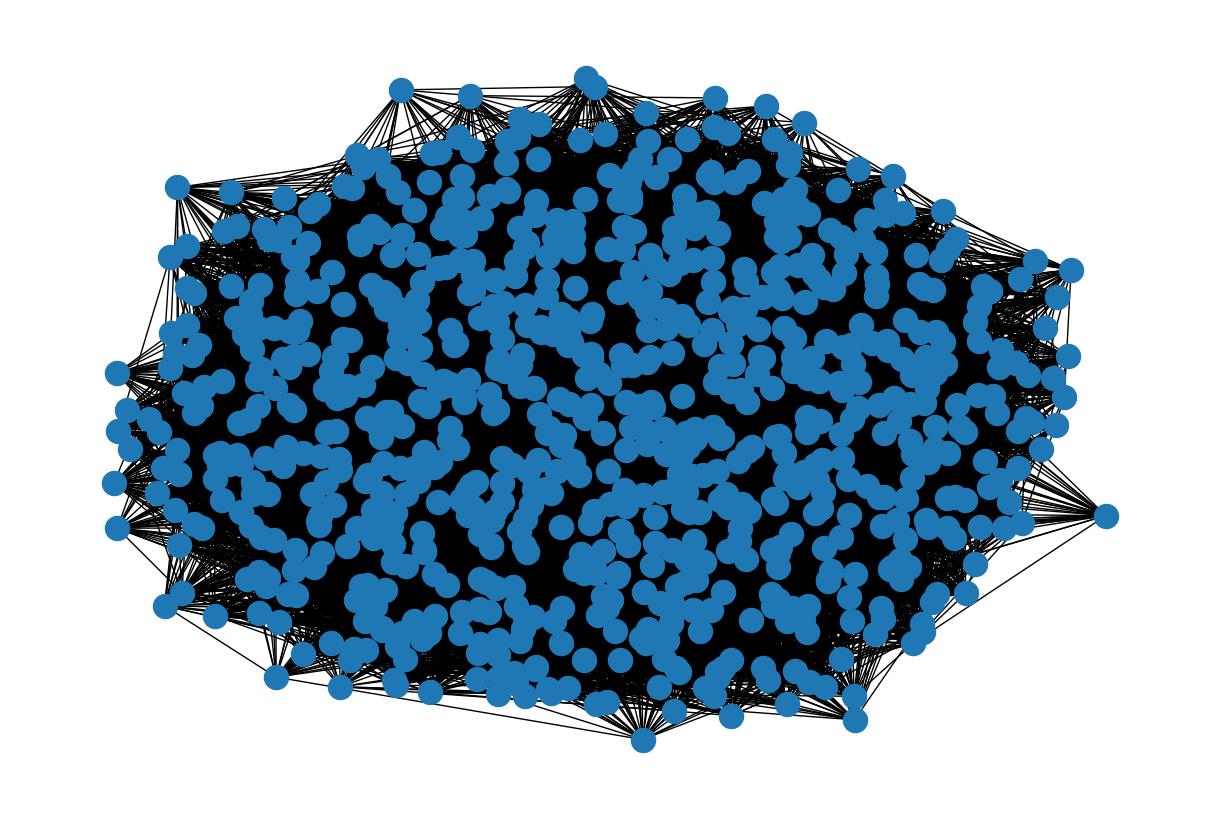

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add edges to the graph
for node1, node2, weight in problem.graph.edges:
    G.add_edge(node1, node2, weight=weight)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G)
plt.show()

Other than this, the problem object works identical to the PBO problems used in the examples above, and you can treat it as a black-box problem. 

## Convenience Functions

To aid you in your analysis, we provide the following wrapper function to run your algorihtm on all instances of a given problem class:

In [28]:
def benchmark_problem_class(algorithm, n_reps: int = 5, budget: int = 50000, problems="MaxCut", root_dir: str = ".", **kwargs):
    fids = [k if problems in v else None for k, v in ioh.ProblemClass.GRAPH.problems.items()]
    fids = [fid for fid in fids if fid is not None]
    logger = ioh.logger.Analyzer(
        root=root_dir,                  
        folder_name=f"{problems}_{algorithm.__name__}",         
        algorithm_name=algorithm.__name__, 
    )
    for k, v in kwargs.items():
        logger.add_experiment_attribute(k, str(v))
    for fid in fids:
        problem = ioh.get_problem(fid, problem_class=ioh.ProblemClass.GRAPH)
        problem.attach_logger(logger)
        for _ in range(n_reps):
            algorithm(budget=budget, **kwargs)(problem)
            problem.reset()


To use this function, simply pass the class of your algorithm (so NOT an instance of the class), together with the settings for the experiment. Any arguments for your constructor (such as mutation rate parameters) can be passed in as additional keyword arguments. For example, we can run the previously created EA with mutation rate 0.05 on all MaxCut problems as follows:

In [29]:
benchmark_problem_class(BinaryEvolutionaryAlgorithm, n_reps=5, budget=50_000, problems="MaxCut", mutation_rate=0.05)

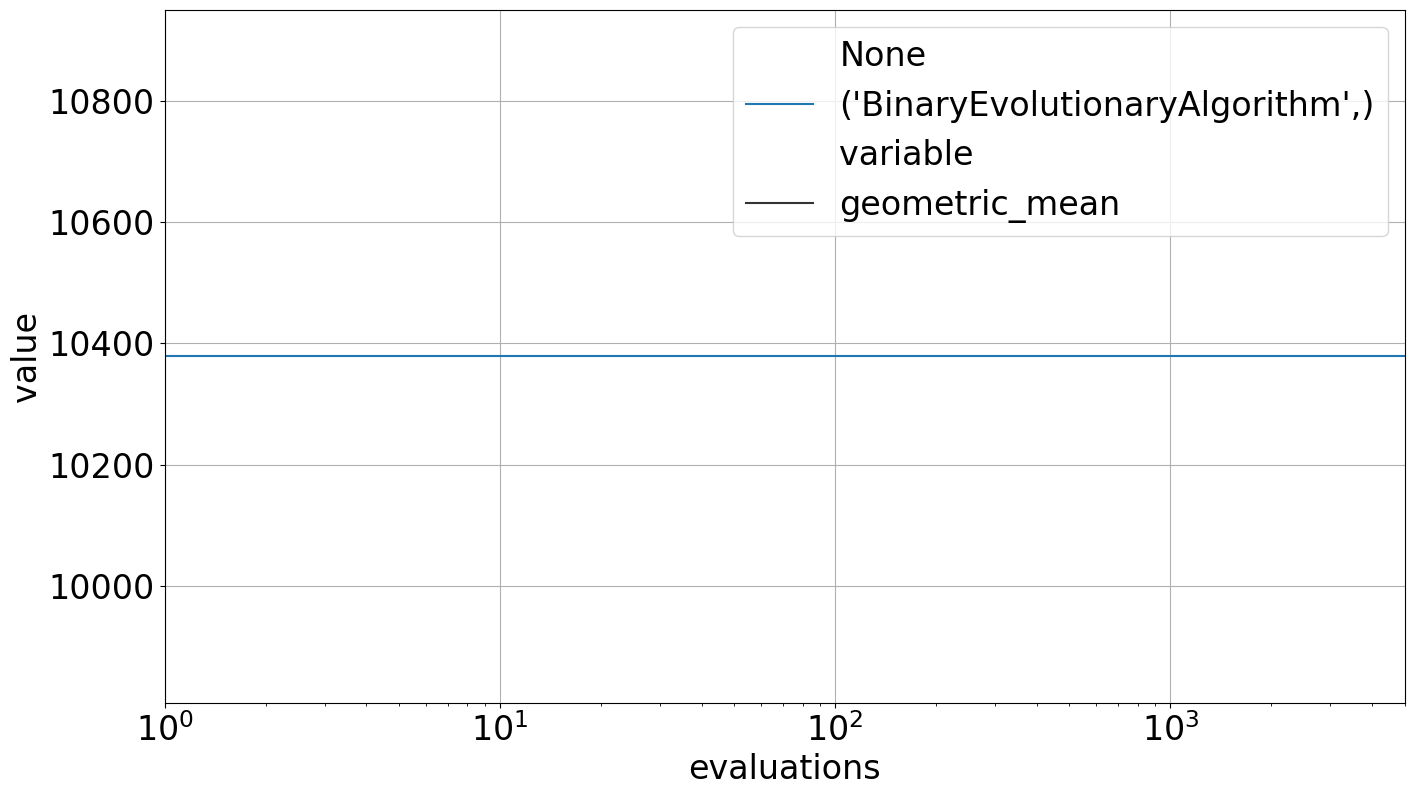

In [ ]:
manager.add_folder("MaxCut_BinaryEvolutionaryAlgorithm")
df = manager.load(True, True)

fig, ax = plt.subplots(figsize=(16, 9))
dt_plot = iohinspector.plot.single_function_fixedbudget(df.filter(pl.col("function_id") == 2004), ax=ax, maximization=True, measures=['mean']) #We need to specify maximization=True 
ax.set_xlim(1, 5000)
ax.grid()
ax.set_yscale('linear')

# Submission Instructions

For your final submission, you should create a single python file (.py extension, so not a notebook). It should contain your algorithm, structured following the template below.

Your algorithm will be tested on unseen instances of the submodular problems. It is therefor important that you make sure your algorithm will run as you intend, so ensure e.g. parameters have default values you want to use. 

For submission, please name your algorithm Name1Name2 based on the names in your team, and use the same name for the file itself (including capitalization). This will enable us to run our tests effectively. If we are unable to run your algorithm on our problems, your entry can't be considered for the leaderboard. 

Use the template below as your starting point:

In [30]:
class Name1Name2:
    """
    Template for implementing your own binary optimization algorithm.
    
    Modify this class to implement your algorithm idea.
    """
    def __init__(self, budget: int = 50_000, **kwargs):
        self.budget = budget
        # Add your algorithm parameters here
        
    def __call__(self, problem: ioh.problem.IntegerSingleObjective) -> None:
        """
        Your algorithm implementation goes here.
        
        Args:
            problem: The binary optimization problem to solve
        """
        # Example: Initialize with random solution
        x = np.random.randint(0, 2, size=problem.meta_data.n_variables)
        problem(x)
        
        # Main optimization loop
        while problem.state.evaluations < self.budget and not problem.state.optimum_found:
            continue
            # TODO: Implement your optimization strategy here